In [25]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [26]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [27]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [28]:
# '맥주'만 빼서 df생성
item = '맥주'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

In [29]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

In [30]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [31]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = gs_day_w.loc[:,list_col]
target = gs_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [32]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [33]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


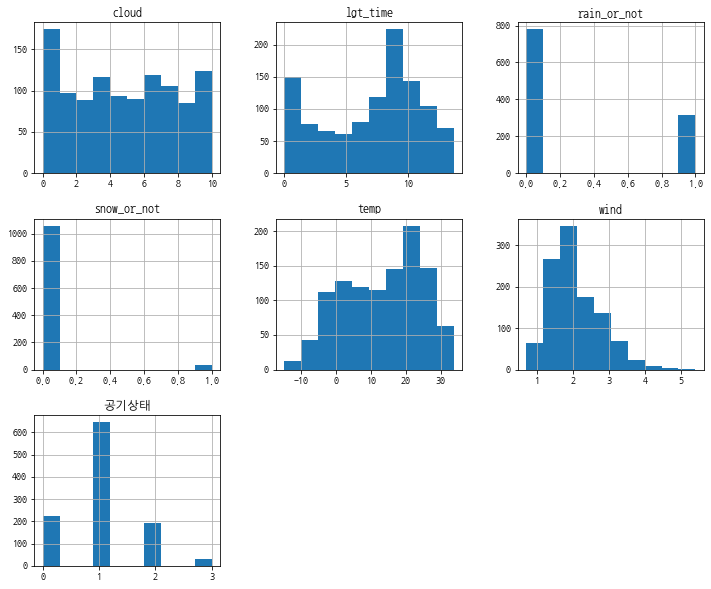

In [34]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

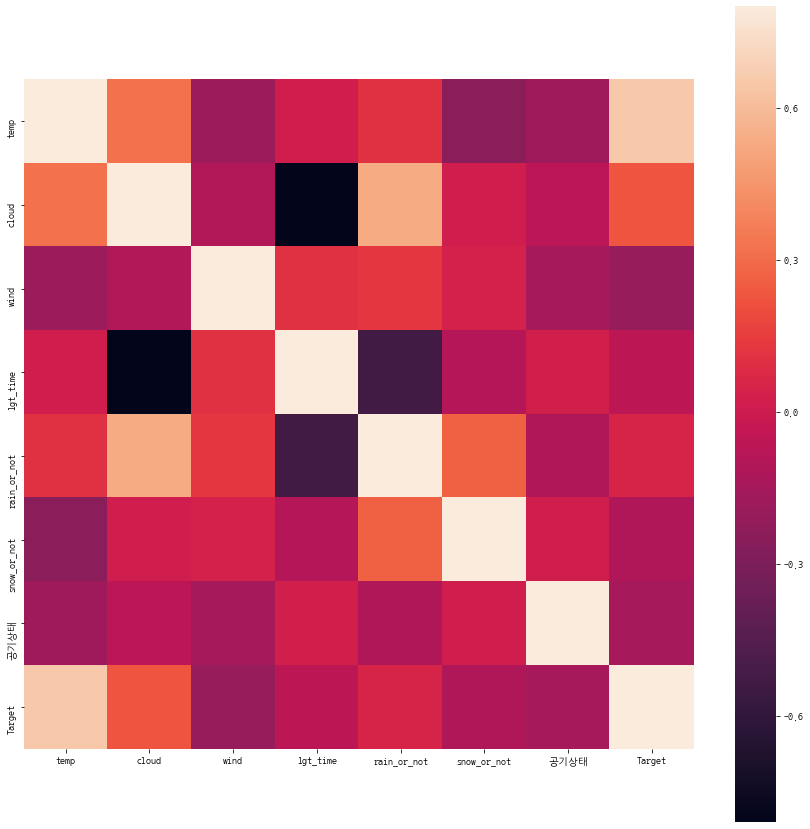

In [35]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [36]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [37]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)
combined.head(1)

,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2
0,1.2,7.0,1.6,2.1,0,0,0,0,1


In [38]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [39]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [40]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [41]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5' 

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [42]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 566us/step - loss: 11601.3567 - mean_absolute_error: 11601.3567 - val_loss: 11578.3776 - val_mean_absolute_error: 11578.3776

Epoch 00001: val_loss improved from inf to 11578.37761, saving model to 맥주date-Weights-001--11578.37761-cat02-vf05.hdf5
Epoch 2/500
585/585 [==============================] - 0s 80us/step - loss: 11056.9085 - mean_absolute_error: 11056.9085 - val_loss: 9554.1973 - val_mean_absolute_error: 9554.1973

Epoch 00002: val_loss improved from 11578.37761 to 9554.19731, saving model to 맥주date-Weights-002--9554.19731-cat02-vf05.hdf5
Epoch 3/500
585/585 [==============================] - 0s 78us/step - loss: 5293.4258 - mean_absolute_error: 5293.4258 - val_loss: 3061.3435 - val_mean_absolute_error: 3061.3435

Epoch 00003: val_loss improved from 9554.19731 to 3061.34352, saving model to 맥주date-Weights-003--3061.34352-cat02-vf05.hdf5
Epoch 4/500
585/585 [==================

585/585 [==============================] - 0s 90us/step - loss: 1759.9145 - mean_absolute_error: 1759.9145 - val_loss: 1563.7600 - val_mean_absolute_error: 1563.7600

Epoch 00033: val_loss did not improve from 1473.14229
Epoch 34/500
585/585 [==============================] - 0s 82us/step - loss: 1752.9506 - mean_absolute_error: 1752.9506 - val_loss: 1561.5924 - val_mean_absolute_error: 1561.5924

Epoch 00034: val_loss did not improve from 1473.14229
Epoch 35/500
585/585 [==============================] - 0s 80us/step - loss: 1712.5009 - mean_absolute_error: 1712.5009 - val_loss: 1494.5241 - val_mean_absolute_error: 1494.5241

Epoch 00035: val_loss did not improve from 1473.14229
Epoch 36/500
585/585 [==============================] - 0s 78us/step - loss: 1736.4870 - mean_absolute_error: 1736.4870 - val_loss: 1534.6829 - val_mean_absolute_error: 1534.6829

Epoch 00036: val_loss did not improve from 1473.14229
Epoch 37/500
585/585 [==============================] - 0s 75us/step - loss: 


Epoch 00066: val_loss did not improve from 1426.22154
Epoch 67/500
585/585 [==============================] - 0s 87us/step - loss: 1573.3811 - mean_absolute_error: 1573.3811 - val_loss: 1454.2465 - val_mean_absolute_error: 1454.2465

Epoch 00067: val_loss did not improve from 1426.22154
Epoch 68/500
585/585 [==============================] - 0s 101us/step - loss: 1635.8877 - mean_absolute_error: 1635.8877 - val_loss: 1400.9757 - val_mean_absolute_error: 1400.9757

Epoch 00068: val_loss improved from 1426.22154 to 1400.97568, saving model to 맥주date-Weights-068--1400.97568-cat02-vf05.hdf5
Epoch 69/500
585/585 [==============================] - 0s 92us/step - loss: 1584.6891 - mean_absolute_error: 1584.6891 - val_loss: 1398.3172 - val_mean_absolute_error: 1398.3172

Epoch 00069: val_loss improved from 1400.97568 to 1398.31718, saving model to 맥주date-Weights-069--1398.31718-cat02-vf05.hdf5
Epoch 70/500
585/585 [==============================] - 0s 94us/step - loss: 1608.3510 - mean_absolu

585/585 [==============================] - 0s 124us/step - loss: 1534.3285 - mean_absolute_error: 1534.3285 - val_loss: 1556.2697 - val_mean_absolute_error: 1556.2697

Epoch 00101: val_loss did not improve from 1385.55206
Epoch 102/500
585/585 [==============================] - 0s 94us/step - loss: 1534.0559 - mean_absolute_error: 1534.0559 - val_loss: 1395.1881 - val_mean_absolute_error: 1395.1881

Epoch 00102: val_loss did not improve from 1385.55206
Epoch 103/500
585/585 [==============================] - 0s 95us/step - loss: 1555.3177 - mean_absolute_error: 1555.3177 - val_loss: 1575.7112 - val_mean_absolute_error: 1575.7112

Epoch 00103: val_loss did not improve from 1385.55206
Epoch 104/500
585/585 [==============================] - 0s 94us/step - loss: 1564.9818 - mean_absolute_error: 1564.9818 - val_loss: 1400.0996 - val_mean_absolute_error: 1400.0996

Epoch 00104: val_loss did not improve from 1385.55206
Epoch 105/500
585/585 [==============================] - 0s 102us/step - 

585/585 [==============================] - 0s 130us/step - loss: 1540.8972 - mean_absolute_error: 1540.8972 - val_loss: 1458.0963 - val_mean_absolute_error: 1458.0963

Epoch 00136: val_loss did not improve from 1385.55206
Epoch 137/500
585/585 [==============================] - 0s 131us/step - loss: 1566.6165 - mean_absolute_error: 1566.6165 - val_loss: 1400.4946 - val_mean_absolute_error: 1400.4946

Epoch 00137: val_loss did not improve from 1385.55206
Epoch 138/500
585/585 [==============================] - 0s 118us/step - loss: 1602.1645 - mean_absolute_error: 1602.1645 - val_loss: 1522.3356 - val_mean_absolute_error: 1522.3356

Epoch 00138: val_loss did not improve from 1385.55206
Epoch 139/500
585/585 [==============================] - 0s 124us/step - loss: 1568.1299 - mean_absolute_error: 1568.1299 - val_loss: 1421.0281 - val_mean_absolute_error: 1421.0281

Epoch 00139: val_loss did not improve from 1385.55206
Epoch 140/500
585/585 [==============================] - 0s 121us/step

585/585 [==============================] - 0s 116us/step - loss: 1464.9288 - mean_absolute_error: 1464.9288 - val_loss: 1387.7712 - val_mean_absolute_error: 1387.7712

Epoch 00170: val_loss did not improve from 1371.40668
Epoch 171/500
585/585 [==============================] - 0s 109us/step - loss: 1501.2234 - mean_absolute_error: 1501.2234 - val_loss: 1379.2324 - val_mean_absolute_error: 1379.2324

Epoch 00171: val_loss did not improve from 1371.40668
Epoch 172/500
585/585 [==============================] - 0s 107us/step - loss: 1506.3907 - mean_absolute_error: 1506.3907 - val_loss: 1533.2484 - val_mean_absolute_error: 1533.2484

Epoch 00172: val_loss did not improve from 1371.40668
Epoch 173/500
585/585 [==============================] - 0s 130us/step - loss: 1505.9339 - mean_absolute_error: 1505.9339 - val_loss: 1623.7842 - val_mean_absolute_error: 1623.7842

Epoch 00173: val_loss did not improve from 1371.40668
Epoch 174/500
585/585 [==============================] - 0s 136us/step

585/585 [==============================] - 0s 147us/step - loss: 1464.2185 - mean_absolute_error: 1464.2185 - val_loss: 1546.2513 - val_mean_absolute_error: 1546.2513

Epoch 00205: val_loss did not improve from 1371.40668
Epoch 206/500
585/585 [==============================] - 0s 123us/step - loss: 1455.6775 - mean_absolute_error: 1455.6775 - val_loss: 1488.9243 - val_mean_absolute_error: 1488.9243

Epoch 00206: val_loss did not improve from 1371.40668
Epoch 207/500
585/585 [==============================] - 0s 142us/step - loss: 1466.4609 - mean_absolute_error: 1466.4609 - val_loss: 1392.8842 - val_mean_absolute_error: 1392.8842

Epoch 00207: val_loss did not improve from 1371.40668
Epoch 208/500
585/585 [==============================] - 0s 147us/step - loss: 1477.5273 - mean_absolute_error: 1477.5273 - val_loss: 1506.4635 - val_mean_absolute_error: 1506.4635

Epoch 00208: val_loss did not improve from 1371.40668
Epoch 209/500
585/585 [==============================] - 0s 162us/step

585/585 [==============================] - 0s 133us/step - loss: 1479.8301 - mean_absolute_error: 1479.8301 - val_loss: 1389.1696 - val_mean_absolute_error: 1389.1696

Epoch 00240: val_loss did not improve from 1371.40668
Epoch 241/500
585/585 [==============================] - 0s 128us/step - loss: 1499.6077 - mean_absolute_error: 1499.6077 - val_loss: 1389.1775 - val_mean_absolute_error: 1389.1775

Epoch 00241: val_loss did not improve from 1371.40668
Epoch 242/500
585/585 [==============================] - 0s 130us/step - loss: 1455.4799 - mean_absolute_error: 1455.4799 - val_loss: 1416.2581 - val_mean_absolute_error: 1416.2581

Epoch 00242: val_loss did not improve from 1371.40668
Epoch 243/500
585/585 [==============================] - 0s 142us/step - loss: 1461.9749 - mean_absolute_error: 1461.9749 - val_loss: 1394.0233 - val_mean_absolute_error: 1394.0233

Epoch 00243: val_loss did not improve from 1371.40668
Epoch 244/500
585/585 [==============================] - 0s 133us/step

585/585 [==============================] - 0s 148us/step - loss: 1452.6149 - mean_absolute_error: 1452.6149 - val_loss: 1412.0227 - val_mean_absolute_error: 1412.0227

Epoch 00275: val_loss did not improve from 1371.40668
Epoch 276/500
585/585 [==============================] - 0s 119us/step - loss: 1450.9061 - mean_absolute_error: 1450.9061 - val_loss: 1390.2610 - val_mean_absolute_error: 1390.2610

Epoch 00276: val_loss did not improve from 1371.40668
Epoch 277/500
585/585 [==============================] - 0s 143us/step - loss: 1482.8234 - mean_absolute_error: 1482.8234 - val_loss: 1444.2791 - val_mean_absolute_error: 1444.2791

Epoch 00277: val_loss did not improve from 1371.40668
Epoch 278/500
585/585 [==============================] - 0s 135us/step - loss: 1527.8577 - mean_absolute_error: 1527.8577 - val_loss: 1413.7474 - val_mean_absolute_error: 1413.7474

Epoch 00278: val_loss did not improve from 1371.40668
Epoch 279/500
585/585 [==============================] - 0s 147us/step

585/585 [==============================] - 0s 128us/step - loss: 1466.5522 - mean_absolute_error: 1466.5522 - val_loss: 1485.0849 - val_mean_absolute_error: 1485.0849

Epoch 00310: val_loss did not improve from 1371.40668
Epoch 311/500
585/585 [==============================] - 0s 157us/step - loss: 1499.3167 - mean_absolute_error: 1499.3167 - val_loss: 1459.1241 - val_mean_absolute_error: 1459.1241

Epoch 00311: val_loss did not improve from 1371.40668
Epoch 312/500
585/585 [==============================] - 0s 155us/step - loss: 1442.4095 - mean_absolute_error: 1442.4095 - val_loss: 1406.0620 - val_mean_absolute_error: 1406.0620

Epoch 00312: val_loss did not improve from 1371.40668
Epoch 313/500
585/585 [==============================] - 0s 143us/step - loss: 1450.8715 - mean_absolute_error: 1450.8715 - val_loss: 1434.1714 - val_mean_absolute_error: 1434.1714

Epoch 00313: val_loss did not improve from 1371.40668
Epoch 314/500
585/585 [==============================] - 0s 159us/step

585/585 [==============================] - 0s 140us/step - loss: 1509.5495 - mean_absolute_error: 1509.5495 - val_loss: 1423.1286 - val_mean_absolute_error: 1423.1286

Epoch 00344: val_loss did not improve from 1371.40668
Epoch 345/500
585/585 [==============================] - 0s 142us/step - loss: 1450.1490 - mean_absolute_error: 1450.1490 - val_loss: 1391.6390 - val_mean_absolute_error: 1391.6390

Epoch 00345: val_loss did not improve from 1371.40668
Epoch 346/500
585/585 [==============================] - 0s 152us/step - loss: 1444.3869 - mean_absolute_error: 1444.3869 - val_loss: 1551.1040 - val_mean_absolute_error: 1551.1040

Epoch 00346: val_loss did not improve from 1371.40668
Epoch 347/500
585/585 [==============================] - 0s 143us/step - loss: 1444.5642 - mean_absolute_error: 1444.5642 - val_loss: 1409.8635 - val_mean_absolute_error: 1409.8635

Epoch 00347: val_loss did not improve from 1371.40668
Epoch 348/500
585/585 [==============================] - 0s 159us/step

585/585 [==============================] - 0s 136us/step - loss: 1456.3295 - mean_absolute_error: 1456.3295 - val_loss: 1546.8787 - val_mean_absolute_error: 1546.8787

Epoch 00379: val_loss did not improve from 1371.40668
Epoch 380/500
585/585 [==============================] - 0s 145us/step - loss: 1485.5716 - mean_absolute_error: 1485.5716 - val_loss: 1373.2940 - val_mean_absolute_error: 1373.2940

Epoch 00380: val_loss did not improve from 1371.40668
Epoch 381/500
585/585 [==============================] - 0s 136us/step - loss: 1451.5675 - mean_absolute_error: 1451.5675 - val_loss: 1419.1176 - val_mean_absolute_error: 1419.1176

Epoch 00381: val_loss did not improve from 1371.40668
Epoch 382/500
585/585 [==============================] - 0s 155us/step - loss: 1427.2519 - mean_absolute_error: 1427.2519 - val_loss: 1397.8539 - val_mean_absolute_error: 1397.8539

Epoch 00382: val_loss did not improve from 1371.40668
Epoch 383/500
585/585 [==============================] - 0s 164us/step


Epoch 00413: val_loss did not improve from 1371.40668
Epoch 414/500
585/585 [==============================] - 0s 124us/step - loss: 1421.9409 - mean_absolute_error: 1421.9409 - val_loss: 1393.9742 - val_mean_absolute_error: 1393.9742

Epoch 00414: val_loss did not improve from 1371.40668
Epoch 415/500
585/585 [==============================] - 0s 159us/step - loss: 1485.0194 - mean_absolute_error: 1485.0194 - val_loss: 1543.4125 - val_mean_absolute_error: 1543.4125

Epoch 00415: val_loss did not improve from 1371.40668
Epoch 416/500
585/585 [==============================] - 0s 162us/step - loss: 1484.6290 - mean_absolute_error: 1484.6290 - val_loss: 1386.7765 - val_mean_absolute_error: 1386.7765

Epoch 00416: val_loss did not improve from 1371.40668
Epoch 417/500
585/585 [==============================] - 0s 153us/step - loss: 1435.0724 - mean_absolute_error: 1435.0724 - val_loss: 1508.5975 - val_mean_absolute_error: 1508.5975

Epoch 00417: val_loss did not improve from 1371.40668
E

585/585 [==============================] - 0s 133us/step - loss: 1433.8483 - mean_absolute_error: 1433.8483 - val_loss: 1573.7729 - val_mean_absolute_error: 1573.7729

Epoch 00448: val_loss did not improve from 1371.40668
Epoch 449/500
585/585 [==============================] - 0s 130us/step - loss: 1454.5964 - mean_absolute_error: 1454.5964 - val_loss: 1522.2840 - val_mean_absolute_error: 1522.2840

Epoch 00449: val_loss did not improve from 1371.40668
Epoch 450/500
585/585 [==============================] - 0s 138us/step - loss: 1446.2744 - mean_absolute_error: 1446.2744 - val_loss: 1411.9425 - val_mean_absolute_error: 1411.9425

Epoch 00450: val_loss did not improve from 1371.40668
Epoch 451/500
585/585 [==============================] - 0s 152us/step - loss: 1446.8594 - mean_absolute_error: 1446.8594 - val_loss: 1394.6579 - val_mean_absolute_error: 1394.6579

Epoch 00451: val_loss did not improve from 1371.40668
Epoch 452/500
585/585 [==============================] - 0s 136us/step

585/585 [==============================] - 0s 138us/step - loss: 1446.3181 - mean_absolute_error: 1446.3181 - val_loss: 1412.9274 - val_mean_absolute_error: 1412.9274

Epoch 00483: val_loss did not improve from 1371.40668
Epoch 484/500
585/585 [==============================] - 0s 135us/step - loss: 1443.5794 - mean_absolute_error: 1443.5794 - val_loss: 1462.5709 - val_mean_absolute_error: 1462.5709

Epoch 00484: val_loss did not improve from 1371.40668
Epoch 485/500
585/585 [==============================] - 0s 155us/step - loss: 1417.9890 - mean_absolute_error: 1417.9890 - val_loss: 1436.4760 - val_mean_absolute_error: 1436.4760

Epoch 00485: val_loss did not improve from 1371.40668
Epoch 486/500
585/585 [==============================] - 0s 145us/step - loss: 1403.9669 - mean_absolute_error: 1403.9669 - val_loss: 1419.6216 - val_mean_absolute_error: 1419.6216

Epoch 00486: val_loss did not improve from 1371.40668
Epoch 487/500
585/585 [==============================] - 0s 143us/step

In [43]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '맥주date-Weights-226--1353.83757-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [44]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.899
검증세트점수 : -1.389
XGBoost을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.661
검증세트점수 : -1.226
LinearRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.454
검증세트점수 : -1.080
RidgeRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.445
검증세트점수 : -1.067
LassoRegression을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.454
검증세트점수 : -1.080
OLS을 이용한 맥주의 회귀분석 결과 :
훈련세트점수 : 0.454
검증세트점수 : -1.080


In [45]:
print(item, 'ols model')

# columns_in_data = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not',
#                     '공기상태_0', '공기상태_1', '공기상태_2']

# formulaGen은 단순 1차 다항식을 제조해준다.
# customF = formulaGen(target='qty',ind_features=columns_in_data)
# customF = formulaGen(target='qty',ind_features=['temp', 'wind','lgt_time','rain_or_not'])
customF = 'qty ~ I(temp**2) + cloud + wind + lgt_time + rain_or_not + snow_or_not'

olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()

print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )

print(olsModel.summary())

맥주 ols model
사람이 직접 식을 때려 박았을때 : -1.128
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     115.5
Date:                Fri, 19 Jul 2019   Prob (F-statistic):          3.74e-102
Time:                        20:56:44   Log-Likelihood:                -6535.5
No. Observations:                 732   AIC:                         1.308e+04
Df Residuals:                     725   BIC:                         1.312e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

In [46]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [52]:
# 예측률 계산
# https://yamalab.tistory.com/46

# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌
# 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# MAPE가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.15
Linear 모델 MAPE 		: 0.17
Ridge 모델 MAPE 		: 0.17
Lasso 모델 MAPE 		: 0.17
OLS 모델 MAPE 			: 0.16


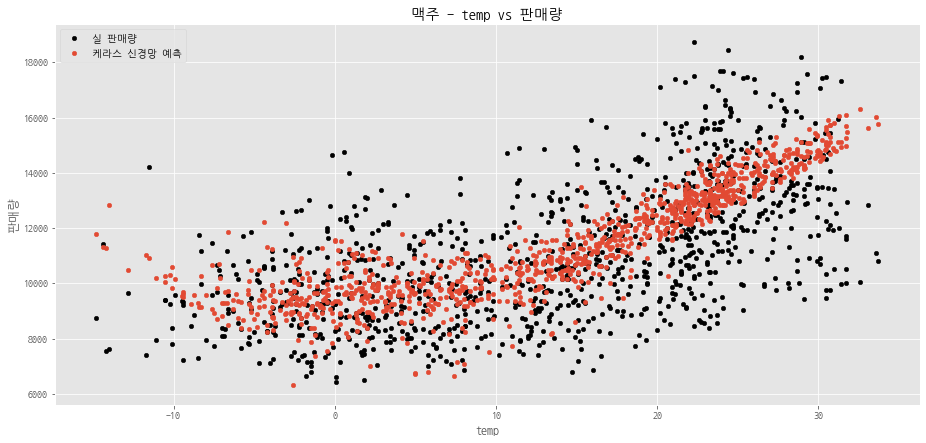

In [51]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2']

# 1~9 : 1 temp ~ 9 공기상태_2
n= 1
# alpha 값 0~1
alp = 1
# scatter plot 점 크기
dot_size = 20

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
# plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

## 실험 구간

In [ ]:

# # 2016~2017 : 훈련 / 2018 검증 2:1
# # 1~106 / 106~156
# trainXy = gs_week_w.loc[:cut_line]
# testXy = gs_week_w.loc[cut_line:]
# train_X =pd.DataFrame(trainXy.loc[:,'temp'])
# train_y = trainXy.loc[:,'qty']
# val_X = pd.DataFrame(testXy.loc[:,'temp'])
# val_y = testXy.loc[:,'qty']



# print('여기서 점수란 R-square값을 의미한다.')
# # RandomForest 회귀분석
# RFmodel = RandomForestRegressor()
# RFmodel.fit(train_X,train_y)
# # Get the mean absolute error on the validation data
# RFpredicted = RFmodel.predict(val_X)
# MAE = mean_absolute_error(val_y , RFpredicted)
# print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# # print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))

# # XGBRegressor 회귀분석
# XGBModel = XGBRegressor(objective='reg:squarederror')
# XGBModel.fit(train_X,train_y , verbose=False)
# # Get the mean absolute error on the validation data :
# XGBpredictions = XGBModel.predict(val_X)
# MAE = mean_absolute_error(val_y , XGBpredictions)
# print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# # print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

# linReg = LinearRegression().fit(train_X, train_y)
# print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

# ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
# print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
# print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

# lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
# print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
# print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

# customF = formulaGen(target='qty',ind_features=['temp'])
# olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
# print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
# print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )

# combined = pd.DataFrame(gs_week_w.loc[:,'temp'])
# target = gs_week_w.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# # predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# result_df = pd.DataFrame()
# result_df['week'] = gs_week_w['week']
# result_df['qty'] = gs_week_w.loc[:,'qty']

# # print("keras 신경망 predictions",predictions.shape)
# # result_df['keras_qty'] = predictions

# # print("randomforest 예상",RFpredicted.shape)
# result_df['rf_qty'] = RFpredicted

# # print("XGBpredictions",XGBpredictions.shape)
# result_df['xgb_qty'] = XGBpredictions

# # print("linearRegression 예상",RFpredicted.shape)
# result_df['lin_qty'] = linPred

# # print("Ridge 예상",RFpredicted.shape)
# result_df['ridge_qty'] = ridPred

# # print("Lasso 예상",RFpredicted.shape)
# result_df['lasso_qty'] = lassoPred

# # print("OLS 예상",RFpredicted.shape)
# result_df['ols_qty'] = olsPred

# ============================================

In [ ]:
# df_graph = result_df.loc[:,['week','qty','keras_qty','rf_qty','xgb_qty','lin_qty','ridge_qty','lasso_qty','ols_qty']]
# for_visual_col = ['week','temp','cloud','wind','lgt_time','snow','rain','PM10']
# df = pd.merge(df_graph, gs_week_w[for_visual_col], on='week', how='left')
# # df.head(1)

In [ ]:
# 2016, 온도
# df_graph = df.loc[df.week <= 53]
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph.temp,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.scatter(df_graph.temp,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.scatter(df_graph.temp,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.scatter(df_graph.temp,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.scatter(df_graph.temp,df_graph.lin_qty, ls='-', label='linear예측')
# plt.scatter(df_graph.temp,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.scatter(df_graph.temp,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.scatter(df_graph.temp,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# qty_columns = list(df_graph.columns)[1:9]
# weather_columns = list(df_graph.columns)[9:]
# print(qty_columns)
# print(weather_columns)

In [ ]:
# x_temp = pd.DataFrame()
# # x_temp['temp'] = list(range(-10,35,1))
# x_temp['temp'] = np.arange(-9,35,0.5)
# combined = x_temp
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.7)
# plt.plot(x_temp, RFpredicted, label = 'rf')
# plt.plot(x_temp, XGBpredictions, label = 'xgb')
# plt.plot(x_temp, linPred, label = 'line')
# plt.plot(x_temp, ridPred, label = 'ridge')
# plt.plot(x_temp, lassoPred, label = 'lasso')
# plt.plot(x_temp, olsPred, label = 'ols')
# plt.plot()
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 실험

In [ ]:
# intercept_lin = linReg.intercept_
# coef_line = linReg.coef_
# # list_col
# linePredict = list()
# x_temp = list(range(-10,38,1))
# for temperature in x_temp:
#     linePredict.append(intercept_lin + coef_line[0]*temperature)

    
# # 2016~2018, 일조시간
# df_graph = df.copy()
# plt.figure(figsize=(15.5, 10))
# plt.scatter(df_graph[weather_columns[0]],df_graph['qty'], ls='-', color='k',label='실 판매량', s=100, alpha=0.3)
# # for q_name in qty_columns:
# #     plt.plot(df_graph[weather_columns[0]],df_graph[q_name], ls='-', label=q_name)
# #     plt.scatter(df_graph.lgt_time,df_graph[q_name], ls='-', label='실제', color='green', alpha=0.5, lw=8)
# #     plt.scatter(df_graph.lgt_time,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# #     plt.scatter(df_graph.lgt_time,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# #     plt.scatter(df_graph.lgt_time,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# #     plt.scatter(df_graph.lgt_time,df_graph.lin_qty, ls='-', label='linear예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.ridge_qty, ls='-', label='ridge예측')
# #     plt.scatter(df_graph.lgt_time,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# #     plt.scatter(df_graph.lgt_time,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.plot(x_temp, linePredict, 'r--', label='linear회귀, 온도만')

# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.xlabel(weather_columns[0])
# plt.ylabel('판매량 (단위 : 1개)')
# plt.show()

# 시간의 경과에 따른 예측량 비교

In [ ]:
# # 2016
# df_graph = result_df.loc[result_df.week <=53]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.legend()
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
# plt.show()

In [ ]:
# # 2017
# df_graph = result_df.loc[(result_df.week >=53)&(result_df.week <=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2018
# df_graph = result_df.loc[(result_df.week >=105)]
# plt.figure(figsize=(15.5, 10))
# plt.plot(df_graph.week,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(df_graph.week,df_graph.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(df_graph.week,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(df_graph.week,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# # 2016~2018
# plt.figure(figsize=(15.5, 10))
# plt.plot(result_df.week,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
# plt.plot(result_df.week,result_df.keras_qty, ls='-', label='keras예측', color='r')
# plt.plot(result_df.week,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
# plt.plot(result_df.week,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
# plt.plot(df_graph.week,df_graph.lin_qty, ls='-', label='linear예측')
# plt.plot(df_graph.week,df_graph.ridge_qty, ls='-', label='ridge예측')
# plt.plot(df_graph.week,df_graph.lasso_qty, ls='-', label='lasso예측',color='yellow')
# plt.plot(df_graph.week,df_graph.ols_qty, ls='-', label='ols예측', color='violet')
# plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
# plt.legend()
# plt.show()

In [ ]:
# def r2_score(v_true, v_pred):
#     ssr = np.sum(np.square(v_pred - np.mean(v_true)))
#     sst = np.sum(np.square(v_true - np.mean(v_true)))
#     return ( ssr / sst)

In [ ]:
# checked_for = '2016~2017'
# combined = aaaaa.loc[:106,'temp':'PM10']
# target = aaaaa.loc[:106,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)
# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2018'
# combined = aaaaa.loc[106:,'temp':'PM10']
# target = aaaaa.loc[106:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# checked_for = '2016~2018'
# combined = aaaaa.loc[:,'temp':'PM10']
# target = aaaaa.loc[:,'qty']

# # 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
# predictions = NN_model.predict(combined)
# # RandomForest 회귀분석 예측 qty생산
# RFpredicted = RFmodel.predict(combined)
# # XGBRegressor 회귀분석 예측 qty생산
# XGBpredictions = XGBModel.predict(combined)
# # linearRegression 회귀분석 예측 qty생산
# linPred = linReg.predict(combined)
# # Ridge 회귀분석 예측 qty생산
# ridPred = ridge.predict(combined)
# # Lasso 회귀분석 예측 qty생산
# lassoPred = lasso.predict(combined)
# # OLS 회귀분석 예측 qty생산
# olsPred = olsModel.predict(combined)

# qty = target

# print(checked_for)
# print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )
# print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )
# print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )
# print('LinReg R2값\t: ','{:<.5f}'.format(r2_score(qty, linPred)) )
# print('Ridge R2값  \t: ','{:<.5f}'.format(r2_score(qty, ridPred)) )
# print('Lasso R2값\t: ','{:<.5f}'.format(r2_score(qty, lassoPred )) )
# print('OLS R2값\t: ','{:<.5f}'.format(r2_score(qty, olsPred )) )

In [ ]:
# path = 'D:/project/contest/data/result/'
# result_df.to_csv(path+item+'_'+grouped_by+'_predict(lowVIF07).csv', encoding='utf-8', index=False)